# Waymo: PET-minTTC relationship

- Scatter plot
    - Total
    - Merge
    - Cross 

In [1]:
import pickle
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scienceplots
from tqdm import tqdm
from shapely import LineString, Point
from seaborn import displot, histplot, relplot, jointplot
plt.style.use(['nature'])

from waymo_devkit.conflict import Conflict

In [2]:
with open('./pkl/conflict_pet15s.pkl', 'rb') as file:
    conflict_list_from_pickle = pickle.load(file)
print(f"#Conflicts: {len(conflict_list_from_pickle)}")

conflict_list = list()
for c in conflict_list_from_pickle:
    conflict_list.append(
        Conflict(
            leader_id=c['leader_id'],
            leader_index=c['leader_index'],
            leader_states=c['leader_states'],
            leader_time_at_conflict=c['leader_time_at_conflict'],
            follower_id=c['follower_id'],
            follower_index=c['follower_index'],
            follower_states=c['follower_states'],
            follower_time_at_conflict=c['follower_time_at_conflict'],
            PET=c['PET'],
            conflict_type=c['conflict_type'],
            leader_is_av=c['leader_is_av'],
            follower_is_av=c['follower_is_av'],
            center=c['center'],
            radius=c['radius'],
            tfrecord_index=c['tfrecord_index'],
            scenario_index=c['scenario_index'],
    ))

#Conflicts: 889


In [3]:
"""
Construct a dataframe with the following columns:
- Conflict type
- Vehicle order
- PET
- minTTC
"""
conflict_cols_in_df = [
    "Conflict type",
    "Vehicle order",
    "PET",
    "minTTC"
]

# generate each rows in the dataframe
conflict_rows_in_df = list()
for index, conflict in tqdm(enumerate(conflict_list)):

    leader_type = "AV" if conflict.leader_is_av else "HV"
    follower_type = "AV" if conflict.follower_is_av else "HV" 
    conflict_type = "Cross" if conflict.conflict_type == "CROSS" else "Merge"
    conflict_rows_in_df.append([
        conflict_type,
        leader_type+"-"+follower_type,
        conflict.PET,
        conflict.minimum_TTC,
    ])
conflict_df = pd.DataFrame(conflict_rows_in_df, columns=conflict_cols_in_df)

# Post-process
PET_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["PET"] <= PET_THRESHOLD]

# display info
conflict_df.info()

889it [00:00, 119434.22it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864 entries, 0 to 888
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  864 non-null    object 
 1   Vehicle order  864 non-null    object 
 2   PET            864 non-null    float64
 3   minTTC         811 non-null    float64
dtypes: float64(2), object(2)
memory usage: 33.8+ KB


In [4]:
# remove nan value
conflict_df = conflict_df.dropna()
conflict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811 entries, 1 to 888
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  811 non-null    object 
 1   Vehicle order  811 non-null    object 
 2   PET            811 non-null    float64
 3   minTTC         811 non-null    float64
dtypes: float64(2), object(2)
memory usage: 31.7+ KB


In [5]:
# Post-process: remove minTTC greater than 10s
minTTC_THRESHOLD = 10
conflict_df = conflict_df[(conflict_df["minTTC"] <= minTTC_THRESHOLD) & (conflict_df["minTTC"] >= 0)]

# display info
conflict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 1 to 888
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  591 non-null    object 
 1   Vehicle order  591 non-null    object 
 2   PET            591 non-null    float64
 3   minTTC         591 non-null    float64
dtypes: float64(2), object(2)
memory usage: 23.1+ KB


In [6]:
conflict_df["Vehicle order"].value_counts()

HV-HV    261
AV-HV    247
HV-AV     83
Name: Vehicle order, dtype: int64

In [7]:
conflict_df["minTTC"].describe()

count    591.000000
mean       5.116998
std        1.731623
min        2.063166
25%        3.737393
50%        4.720153
75%        6.234004
max        9.959505
Name: minTTC, dtype: float64

## Scatterplots

In [8]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}

Text(9.972222222222223, 0.5, 'PET (s)')

<Figure size 300x300 with 0 Axes>

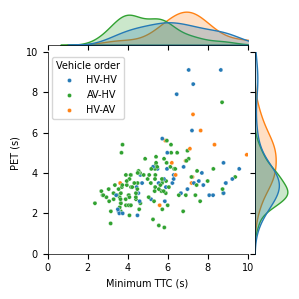

In [10]:
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
OFFSET = 0.5
conflictType = "Merge"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

g = jointplot(
    data=conflict_df[conflict_df["Conflict type"] == conflictType],
    x="minTTC",
    y="PET",  
    hue="Vehicle order",
    palette=palette,
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    height=FIGURE_HEIGHT,
    xlim=[0, minTTC_THRESHOLD], ylim=[0, PET_THRESHOLD],
    # xlim=[-OFFSET, minTTC_THRESHOLD+OFFSET], ylim=[-OFFSET, PET_THRESHOLD+OFFSET],
    # joint_kws={'common_norm': True},
    marginal_kws={'common_norm': False}
)

plt.xlabel("Minimum TTC (s)")
plt.ylabel("PET (s)")

# plt.savefig(f"./outputs/plots/pet_ttc_waymo_merge.png", dpi=400, bbox_inches='tight')

Text(9.972222222222223, 0.5, 'PET (s)')

<Figure size 300x300 with 0 Axes>

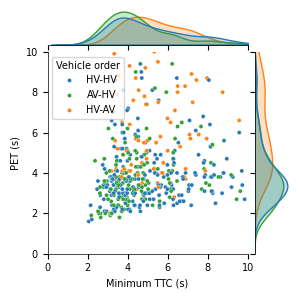

In [11]:
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
OFFSET = 0.5
conflictType = "Cross"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

g = jointplot(
    data=conflict_df[conflict_df["Conflict type"] == conflictType],
    x="minTTC",
    y="PET",  
    hue="Vehicle order",
    palette=palette,
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    height=FIGURE_HEIGHT,
    xlim=[0, minTTC_THRESHOLD], ylim=[0, PET_THRESHOLD],
    # xlim=[-OFFSET, minTTC_THRESHOLD+OFFSET], ylim=[-OFFSET, PET_THRESHOLD+OFFSET],
    # joint_kws={'common_norm': True},
    marginal_kws={'common_norm': False}
)

plt.xlabel("Minimum TTC (s)")
plt.ylabel("PET (s)")

# plt.savefig(f"./outputs/plots/pet_ttc_waymo_cross.png", dpi=400, bbox_inches='tight')

## Scatterplots

### All

In [ ]:
# palette = {
#     "HV-HV" : '#257ab6', 
#     "AV-HV" : '#31a231',
#     "HV-AV" : '#ff8214',
# }

# HVHV_COLOR = '#257ab6'
# HVAV_COLOR = '#31a231'
# AVHV_COLOR = '#ff8214'

# FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
# conflictType = "Total"
# plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

# # scatterplots
# g = relplot(
#     data=conflict_df,
#     x="minTTC",
#     y="PET",
#     # size=1,
#     hue="Vehicle order",
#     col="Vehicle order",
#     col_order=["HV-HV", "AV-HV", "HV-AV"],
#     palette=palette,
#     height=FIGURE_HEIGHT,
#     aspect=0.9,
#     legend=False,
# )
# g.axes[0,0].set_xlim([0, minTTC_THRESHOLD])
# g.axes[0,0].set_ylim([0, PET_THRESHOLD])

# # suptitle and its location
# g.set_titles("{col_name}")
# g.fig.suptitle(f"PET-min TTC relationship [{conflictType}] (Waymo)", size=10)
# g.figure.subplots_adjust(top=.85)

# plt.savefig(f"./outputs/plots/waymo_scatterplot_PET_minTTC_{conflictType}.png", dpi=300, bbox_inches="tight")
# plt.show()

### Merge

In [ ]:
# FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
# conflictType = "Merge"
# plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

# # scatterplots
# g = relplot(
#     data=conflict_df[conflict_df["Conflict type"] == conflictType],
#     x="minTTC",
#     y="PET",
#     size=1,
#     hue="Vehicle order",
#     col="Vehicle order",
#     col_order=["HV-HV", "AV-HV", "HV-AV"],
#     palette=palette,
#     height=FIGURE_HEIGHT,
#     aspect=0.9,
#     legend=False,
# )
# g.axes[0,0].set_xlim([0, minTTC_THRESHOLD])
# g.axes[0,0].set_ylim([0, PET_THRESHOLD])

# # suptitle and its location
# g.set_titles("{col_name}")
# g.fig.suptitle(f"PET-min TTC relationship [{conflictType}] (Waymo)", size=10)
# g.figure.subplots_adjust(top=.85)

# plt.savefig(f"./outputs/plots/waymo_scatterplot_PET_minTTC_{conflictType}.png", dpi=300, bbox_inches="tight")
# plt.show()

### Cross

In [ ]:
# FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
# conflictType = "Cross"
# plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

# # scatterplots
# g = relplot(
#     data=conflict_df[conflict_df["Conflict type"] == conflictType],
#     x="minTTC",
#     y="PET",
#     size=1,
#     hue="Vehicle order",
#     col="Vehicle order",
#     col_order=["HV-HV", "AV-HV", "HV-AV"],
#     palette=palette,
#     height=FIGURE_HEIGHT,
#     aspect=0.9,
#     legend=False,
# )
# g.axes[0,0].set_xlim([0, minTTC_THRESHOLD])
# g.axes[0,0].set_ylim([0, PET_THRESHOLD])

# # suptitle and its location
# g.set_titles("{col_name}")
# g.fig.suptitle(f"PET-min TTC relationship [{conflictType}] (Waymo)", size=10)
# g.figure.subplots_adjust(top=.85)

# plt.savefig(f"./outputs/plots/waymo_scatterplot_PET_minTTC_{conflictType}.png", dpi=300, bbox_inches="tight")
# plt.show()